<a href="https://colab.research.google.com/github/nateej/deep-learning-dataset/blob/master/Natnael_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, itertools
import time
import numpy as np
import pandas as pd
import random, shutil
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from keras import layers,regularizers


from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization,Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import backend as K

In [ ]:
from keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report,  ConfusionMatrixDisplay

In [ ]:
has_gpu = torch.cuda.is_available()
#for mac
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")  ## This part check if you are using gpu or not

GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda


<ipython-input-4-4437df007438>:3: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  has_mps = getattr(torch,'has_mps',False)
<ipython-input-4-4437df007438>:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch,'has_mps',False) \


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [02:01<00:00, 23.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [ ]:
base_dir  = '/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")

In [ ]:
output_dir = "/root/Final_Project_dataset"
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

In [ ]:
images = []
labels = []
classes = os.listdir(train_dir)

In [ ]:
for class_name in classes:
    class_train_path = os.path.join(train_dir, class_name)  ## Construct the paths for the class specific directories
    class_val_path = os.path.join(val_dir, class_name)
    class_train_images = [os.path.join(class_train_path, img) for img in os.listdir(class_train_path) if os.path.isfile(os.path.join(class_train_path, img))] ##Get the list of image file paths for the training data
    class_val_images = [os.path.join(class_val_path, img) for img in os.listdir(class_val_path) if os.path.isfile(os.path.join(class_val_path, img))]          ##Get the list of image file paths for the Validation data
    images.extend(class_train_images + class_val_images) ## Adds all image file paths (training + validation) for the current class to the main images list
    labels.extend([class_name] * (len(class_train_images) + len(class_val_images)))  ## Adds the corresponding class labels for the images to the labels list

In [ ]:
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.35, random_state=42, stratify=labels
)  ## 35% of the dataset will be allocated to the temporary set and leaving the remaining 65% for the training set

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels  # 0.5 * 35% ≈ 17.5%
)  ## 50% of the temporary set will go to the test set (0.5 * 35% ≈ 17.5%) and approximately 17.5% goes to validation set

In [ ]:
def copy_images(image_paths, labels, dest_dir):
    for img_path, label in zip(image_paths, labels):
        label_dir = os.path.join(dest_dir, label) ## Constructs the path to a subdirectory under dest_dir for the current label and Joins dest_dir and label to create a full path for the label-specific directory
        os.makedirs(label_dir, exist_ok=True)    ##  Creates the directory specified by label_dir if it doesn't already exist.
        shutil.copy(img_path, os.path.join(label_dir, os.path.basename(img_path))) ## Copies the image file (img_path) into the label-specific director

In [ ]:
copy_images(train_images, train_labels, os.path.join(output_dir, 'train'))
copy_images(val_images, val_labels, os.path.join(output_dir, 'val'))
copy_images(test_images, test_labels, os.path.join(output_dir, 'test'))

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    rotation_range=30,  # Random rotation up to 30 degrees
    width_shift_range=0.2,  # Horizontal shift up to 20% of the image width
    height_shift_range=0.2,  # Vertical shift up to 20% of the image height
    shear_range=0.2,  # Shearing transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Filling strategy for newly created pixels
)

# Data generator for validation (no augmentation, only normalization)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Data generator for test (no augmentation, only normalization)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create data loaders
train_data = train_datagen.flow_from_directory(
    output_dir + '/train',
    class_mode='categorical',
    batch_size=64,
    target_size=(224, 224)
)

val_data = val_datagen.flow_from_directory(
    output_dir + '/val',
    class_mode='categorical',
    batch_size=64,
    target_size=(224, 224)
)

test_data = test_datagen.flow_from_directory(
    output_dir + '/test',
    class_mode='categorical',
    batch_size=10,
    target_size=(224, 224)
)

Found 57113 images belonging to 38 classes.
Found 15377 images belonging to 38 classes.
Found 15377 images belonging to 38 classes.


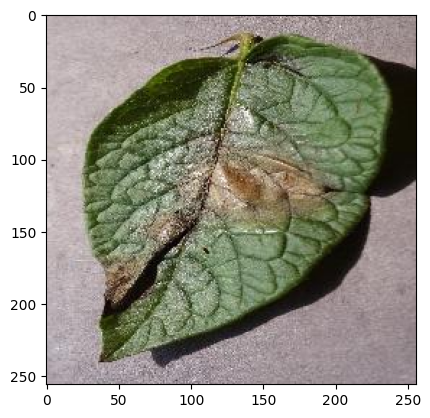

In [ ]:
directory = os.listdir(output_dir+'/test')
random_class = random.choice(directory)
image_files = os.listdir(os.path.join(output_dir, 'test', random_class))
sample = random.choice(image_files)
img = load_img(os.path.join(output_dir+'/test',random_class,sample))
plt.imshow(img)
plt.show()

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5.keras',   # where to save the model
    monitor='val_accuracy',     # metric to monitor
    mode='max',                 # save when accuracy is maximized
    save_best_only=True,        # only save the best model
    verbose=1
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-4:]:
    layer.trainable = True     ## Unfreezing the last four layers of the model to make them trainable, allowing the network to fine-tune task-specific features.

model = Sequential()
model.add(base_model)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(38, activation='softmax')  # Output layer for 38 classes
])
optimizer = Adam(learning_rate=1e-4)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 38)                  │           2,470 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,059,942 (76.52 MB)

 Trainable params: 20,059,814 (76.52 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [ ]:
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_score])
history = model.fit(train_data, epochs=10, validation_data = val_data,class_weight=class_weights, verbose=1)

Epoch 1/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 645s 708ms/step - accuracy: 0.9839 - f1_score: 0.8046 - loss: 0.0863 - val_accuracy: 0.9802 - val_f1_score: 0.7919 - val_loss: 0.0847
Epoch 2/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 631s 701ms/step - accuracy: 0.9861 - f1_score: 0.8029 - loss: 0.0746 - val_accuracy: 0.9850 - val_f1_score: 0.8030 - val_loss: 0.0641
Epoch 3/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 630s 701ms/step - accuracy: 0.9879 - f1_score: 0.8030 - loss: 0.0674 - val_accuracy: 0.9838 - val_f1_score: 0.8006 - val_loss: 0.0630
Epoch 4/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 632s 703ms/step - accuracy: 0.9860 - f1_score: 0.8084 - loss: 0.0703 - val_accuracy: 0.9855 - val_f1_score: 0.8022 - val_loss: 0.0685
Epoch 5/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 631s 701ms/step - accuracy: 0.9909 - f1_score: 0.8073 - loss: 0.0500 - val_accuracy: 0.9771 - val_f1_score: 0.7918 - val_loss: 0.0836
Epoch 6/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 631s 701ms/step - accuracy: 0.9860 - f1_score: 0.8098 - loss: 0.0697 - val_accuracy: 0.981

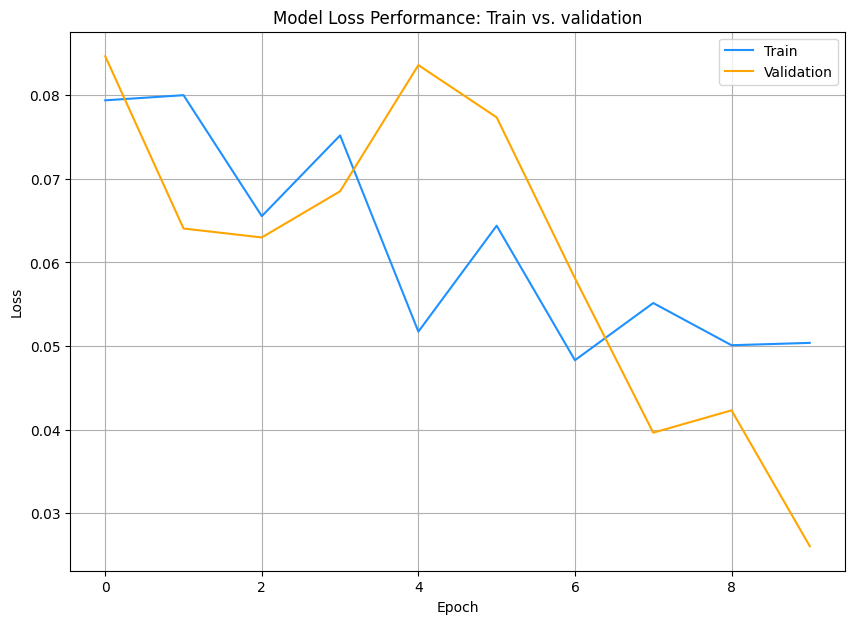

In [ ]:
J = history.history['loss']  # Loss data for Training
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

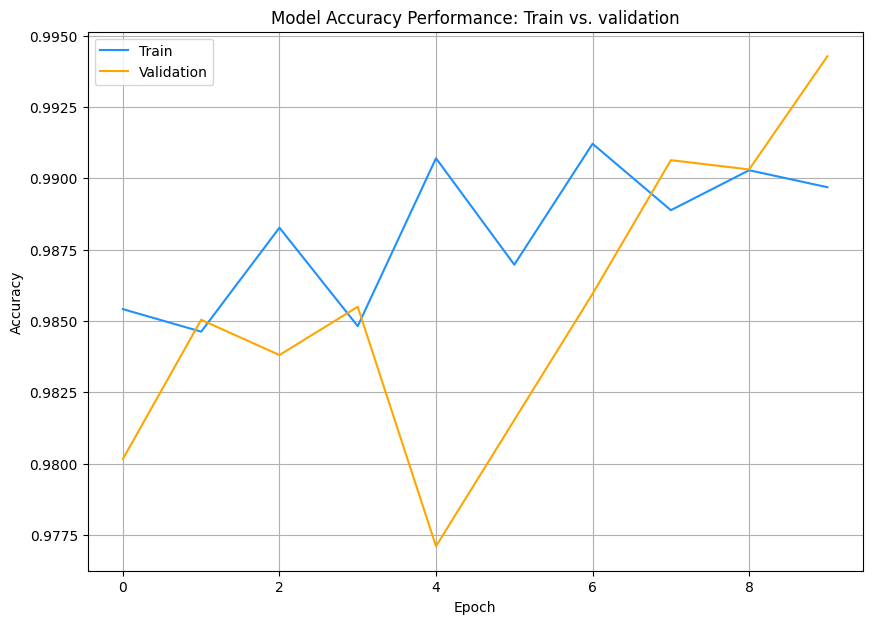

In [ ]:
accu = history.history['accuracy']  # Loss data for Training
accu_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Accuracy Performance: Train vs. validation')
plt.plot(accu, color='DodgerBlue', label='Train')
plt.plot(accu_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()